## Power analysis for spatial kernel design

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import itertools
import scanpy as sc
from splisosm.utils import load_visium_sp_meta, extract_counts_n_ratios, extract_gene_level_statistics
from splisosm import SplisosmNP

import matplotlib.pyplot as plt

### Limitation of low-rank kernel approximation

#### Simulate coordinates and patterns on a grid

In [2]:
# simulate coordinates
x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)
coords = np.array(list(itertools.product(x, y)))
coords = coords - coords.mean(axis = 0, keepdims=True)

In [3]:
def spatial_pattern(x, y):
    return np.sin(10 * np.pi * x) * np.cos(10 * np.pi * y) + x**2 - y**2

# simulate an arbitrary grid pattern
z_grid = spatial_pattern(coords[:, 0], coords[:, 1]) # (2500,)
z_grid = z_grid - z_grid.mean()
z_grid = z_grid / z_grid.max()

In [4]:
from PIL import Image

# load a image of world map
image_path = "/Users/jysumac/Projects/SPLISOSM_paper/results/hippo_slideseqv2/worldmap.png"
image = Image.open(image_path).convert("L")  # Convert to grayscale ('L' mode)

# convert it into a numpy array
z_map = np.array(image.resize((50, 50))).reshape(-1) # (2500, )
z_map = z_map - z_map.mean()
z_map = z_map / z_map.max()

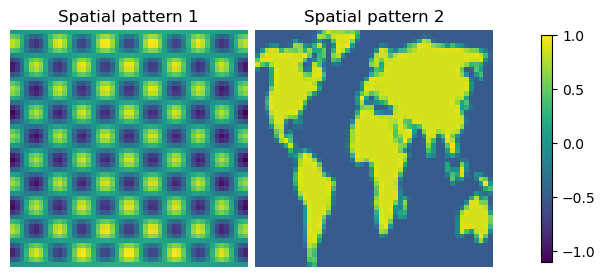

In [5]:
# visualize the two patterns
z_list = [z_grid, z_map]

fig, axes = plt.subplots(1, len(z_list), figsize=(3 * len(z_list), 3), constrained_layout=True)

# Find the global min and max values across all Z arrays for a shared color scale
vmin = min(z.min() for z in z_list)
vmax = max(z.max() for z in z_list)

# Plot each heatmap
for i, z in enumerate(z_list):
    im = axes[i].imshow(z.reshape(50, 50), cmap='viridis', interpolation='nearest', vmin=vmin, vmax=vmax)
    axes[i].set_title(f'Spatial pattern {i + 1}')
    axes[i].axis('off')  # Optional: Turn off axes for a cleaner look

# Add a shared color bar
cbar = fig.colorbar(im, ax=axes, orientation='vertical', shrink=0.8, pad=0.1)

# Display the heatmaps
plt.show()

#### SPARK-X kernel

In [6]:
# SPARK-X's transformation function rewritten in python
def transloc_func(coord, lker, transfunc="gaussian"):
    """
    Simulates a transformation on the given coordinates.

    Parameters:
    - coord (numpy array): Input coordinates.
    - lker (int): Index for selecting quantile-based scaling.
    - transfunc (str): The transformation function, either "gaussian" or "cosine".

    Returns:
    - numpy array: Transformed coordinates.
    """
    # Center the coordinates by removing the mean (scale = False in R's scale function)
    coord = coord - np.mean(coord)

    # Compute quantiles of the absolute values of the coordinates
    l = np.quantile(np.abs(coord), q=np.arange(0.2, 1.2, 0.2))  # quantiles at 0.2, 0.4, 0.6, 0.8, 1.0

    # Apply the transformation based on the transfunc argument
    if transfunc == "gaussian":
        out = np.exp(-coord**2 / (2 * l[lker - 1]**2))  # lker - 1 to account for Python's 0-based indexing
    elif transfunc == "cosine":
        out = np.cos(2 * np.pi * coord / l[lker - 1])
    else:
        raise ValueError("Invalid transfunc. Choose 'gaussian' or 'cosine'.")

    return out

def _run_sparkx(coordinates, counts_g):
    """Wrapper for running the SPARK-X test for spatial gene expression variability.

    Args:
        coordinates: (n_spots, 2), the spatial coordinates.
        counts_g: (n_spots, n_genes), the observed counts for each gene.

    Returns:
        sv_sparkx: dict, the results from the SPARK-X test.
    """
    # load packages neccessary for running SPARK-X
    import rpy2
    import rpy2.robjects as ro
    from rpy2.robjects import r
    from rpy2.robjects import numpy2ri
    from rpy2.robjects import pandas2ri
    from rpy2.robjects.packages import importr
    numpy2ri.activate()
    pandas2ri.activate()
    spark = importr('SPARK')

    # prepare robject inputs
    if isinstance(coordinates, torch.Tensor):
        coordinates = coordinates.numpy()
    coords_r = ro.conversion.py2rpy(coordinates) # (n_spots, 2)
    counts_r = ro.conversion.py2rpy(counts_g.T) # (n_genes, n_spots)
    counts_r.colnames = ro.vectors.StrVector(r['rownames'](coords_r))

    # run SPARK-X and extract outputs
    sparkx_res = spark.sparkx(counts_r, coords_r)
    sv_sparkx = ro.conversion.rpy2py(sparkx_res.rx['res_mtest'][0])
    sv_sparkx = {
        'statistic': ro.conversion.rpy2py(sparkx_res.rx['stats'][0]),
        'pvalue': ro.conversion.rpy2py(sparkx_res.rx['res_mtest'][0])['combinedPval'].values,
        'pvalue_adj': ro.conversion.rpy2py(sparkx_res.rx['res_mtest'][0])['adjustedPval'].values,
        'method': 'spark-x',
    }

    return sv_sparkx

def get_sparkx_kernel_Q(coords):
    """Compute the explisit SPARK-X kernel (rank = 22)"""
    Q_list = [coords]
    for iker in range(1, 6):
        Q_list.append(transloc_func(coords, iker, 'gaussian'))
        Q_list.append(transloc_func(coords, iker, 'cosine'))

    # concatenate rank-2 kernels
    Q = np.concat(Q_list, axis = 1)
    Q = Q - Q.mean(0, keepdims = True)

    return Q

def get_sparkx_null_eigvecs(coords):
    """Compute the basis of null(Q)"""
    Q = get_sparkx_kernel_Q(coords)
    _, U = np.linalg.eigh(Q @ Q.T) # sorted by ascending order
    U_trunc = U[:, :-22]
    return U_trunc

In [7]:
# transform the pattern z into z_hat where the SPARK-X kernel has zero power
U_trunc = get_sparkx_null_eigvecs(coords)
print(U_trunc.shape)

z_hat = []
for z in [z_grid, z_map]:
    # solve U_trunc @ w = z
    z_hat.append(U_trunc @ (U_trunc.T @ z))
    # w, _, _, _ = np.linalg.lstsq(U_trunc, z)
    # z_hat.append(U_trunc @ w)

(2500, 2478)


In [8]:
# run SPARK-X on original and transformed Z
z_list = [z_grid, z_hat[0], z_map, z_hat[1]]
sparkx_res = _run_sparkx(coords, np.vstack(z_list).T)
sparkx_res

## ===== SPARK-X INPUT INFORMATION ==== 
## number of total samples: 2500 
## number of total genes: 4 
## Running with single core, may take some time 
## Testing With Projection Kernel
## Testing With Gaussian Kernel 1
## Testing With Gaussian Kernel 2
## Testing With Gaussian Kernel 3
## Testing With Gaussian Kernel 4
## Testing With Gaussian Kernel 5
## Testing With Cosine Kernel 1
## Testing With Cosine Kernel 2
## Testing With Cosine Kernel 3
## Testing With Cosine Kernel 4
## Testing With Cosine Kernel 5


{'statistic': array([[3.99299554e-02, 6.46984021e+01, 1.02334125e+02, 1.11477720e+02,
         1.13612451e+02, 1.14263151e+02, 1.44680425e+00, 4.87595902e-03,
         1.02132029e+01, 1.55572669e+01, 9.28700786e+00],
        [2.35820896e-30, 6.03289137e-22, 6.33275475e-19, 7.86998477e-18,
         1.66113163e-20, 2.49457200e-17, 1.82308744e-29, 2.08805181e-27,
         8.97413966e-25, 7.84416095e-25, 2.73598461e-22],
        [2.63962143e+02, 2.96738792e+01, 6.42959644e+01, 9.93953574e+01,
         1.16469390e+02, 1.25190340e+02, 3.75524480e+00, 3.90807668e-01,
         1.63172478e+02, 2.65148443e+01, 1.18234716e+02],
        [3.75237420e-30, 2.15717729e-22, 4.44251391e-18, 2.11006491e-16,
         1.45684856e-15, 1.04105731e-15, 2.93418252e-26, 1.54622386e-26,
         7.28863410e-25, 3.11827419e-24, 5.23587469e-22]]),
 'pvalue': array([8.59575974e-25, 1.00000000e+00, 5.28130818e-57, 1.00000000e+00]),
 'pvalue_adj': array([3.58156656e-24, 1.00000000e+00, 4.40109015e-56, 1.00000000e+00]

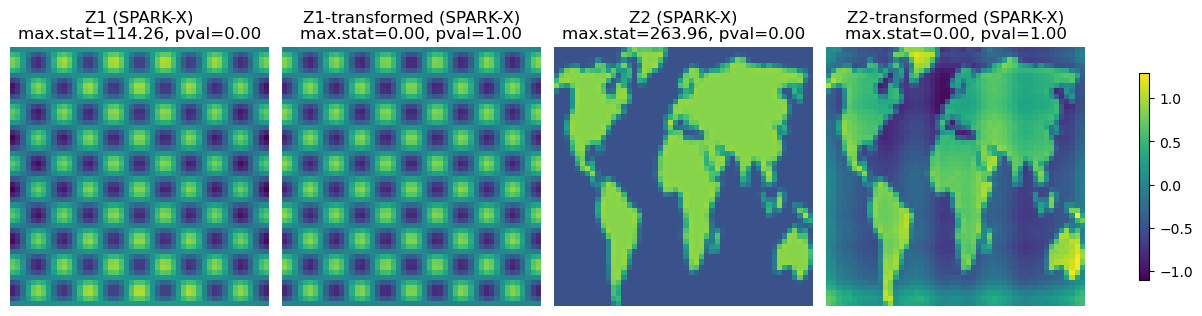

In [9]:
# visualize the two patterns
z_list = [z_grid, z_hat[0], z_map, z_hat[1]]
z_names = ['Z1', 'Z1-transformed', 'Z2', 'Z2-transformed']

fig, axes = plt.subplots(1, len(z_list), figsize=(3 * len(z_list), 3), constrained_layout=True)

# Find the global min and max values across all Z arrays for a shared color scale
vmin = min(z.min() for z in z_list)
vmax = max(z.max() for z in z_list)

# Plot each heatmap
for i, z in enumerate(z_list):
    im = axes[i].imshow(z.reshape(50, 50), cmap='viridis', interpolation='nearest', vmin=vmin, vmax=vmax)
    axes[i].set_title(
        f'{z_names[i]} (SPARK-X)\nmax.stat={sparkx_res['statistic'][i,:].max():.2f}, '
        f'pval={sparkx_res['pvalue'][i]:.2f}'
    )
    axes[i].axis('off')  # Optional: Turn off axes for a cleaner look

# Add a shared color bar
cbar = fig.colorbar(im, ax=axes, orientation='vertical', shrink=0.8)

# Display the heatmaps
plt.show()

#### Low-rank GFT kernel

In [10]:
import scipy
from smoother.weights import coordinate_to_weights_knn_sparse, sparse_weights_to_inv_cov

# compute the inverse covariance matrix
swm = coordinate_to_weights_knn_sparse(coords, k=4, symmetric = True, row_scale = False)
inv_cov = sparse_weights_to_inv_cov(
    swm, model='icar', rho=0.99, standardize=False, return_sparse = True
).coalesce() # (n_spots, n_spots), sparse

# normalize by degree matrix
row_sum = torch.sparse.sum(swm, 1).to_dense()
inv_cov.values()[:] = inv_cov.values() / row_sum[inv_cov.indices()[0]].pow(0.5)
inv_cov.values()[:] = inv_cov.values() / row_sum[inv_cov.indices()[1]].pow(0.5)

# compute the eigendecomposition (i.e. graph fourier modes)
eigvals, eigvecs = np.linalg.eigh(inv_cov.to_dense().numpy())
V = eigvecs[:,::-1] # sort by ascending order

# # convert it to standardized spatial covariance
# cov = torch.cholesky_inverse(torch.linalg.cholesky(inv_cov.to_dense()))
# inv_sds = torch.diagflat(torch.diagonal(cov) ** (-0.5))
# cov = inv_sds @ cov @ inv_sds

# # compute the eigendecomposition (i.e. graph fourier modes)
# eigvals, eigvecs = np.linalg.eigh(cov.numpy())
# V = eigvecs # sort by ascending order

In [11]:
# transform the grid pattern
z_grid_list = []
for _rank in [2, 20, 200, 1000]:
    # solve V_trunc @ w = z
    V_trunc = V[:, :-_rank]
    z_grid_list.append(V_trunc @ (V_trunc.T @ z_grid))
    # w, _, _, _ = np.linalg.lstsq(V_trunc, z_grid)
    # z_grid_list.append(V_trunc @ w)

# transform the world map
z_map_list = []
for _rank in [2, 20, 200, 1000]:
    # solve V_trunc @ w = z
    V_trunc = V[:, :-_rank]
    z_map_list.append(V_trunc @ (V_trunc.T @ z_map))
    # w, _, _, _ = np.linalg.lstsq(V_trunc, z_map)
    # z_map_list.append(V_trunc @ w)

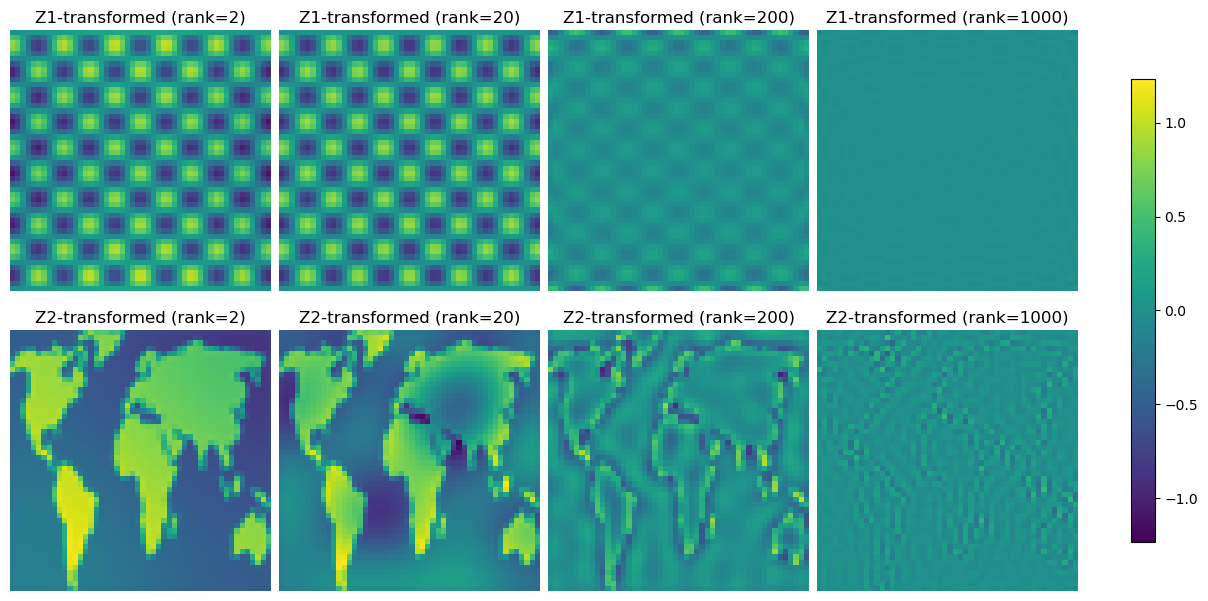

In [12]:
# Create subplots (1 row, num_heatmaps columns)
z_rank = [2, 20, 200, 1000]

fig, axes = plt.subplots(2, len(z_rank), figsize=(3 * len(z_rank), 6), constrained_layout=True)

# Find the global min and max values across all Z arrays for a shared color scale
vmin = min(z.min() for z in z_grid_list + z_map_list)
vmax = max(z.max() for z in z_grid_list + z_map_list)

# Plot each heatmap
for i, z in enumerate(z_grid_list):
    im = axes[0, i].imshow(z.reshape(50, 50), cmap='viridis', interpolation='nearest', vmin=vmin, vmax=vmax)
    axes[0, i].set_title(f'Z1-transformed (rank={z_rank[i]})')
    axes[0, i].axis('off')  # Optional: Turn off axes for a cleaner look

for i, z in enumerate(z_map_list):
    im = axes[1, i].imshow(z.reshape(50, 50), cmap='viridis', interpolation='nearest', vmin=vmin, vmax=vmax)
    axes[1, i].set_title(f'Z2-transformed (rank={z_rank[i]})')
    axes[1, i].axis('off')  # Optional: Turn off axes for a cleaner look

# Add a shared color bar
cbar = fig.colorbar(im, ax=axes, orientation='vertical', shrink=0.8)

# Display the heatmaps
plt.show()

### Slideseq-V2 SV tests using approximated kernel

In [13]:
%load_ext memory_profiler

res_dir = '/Users/jysumac/Projects/SPLISOSM_paper/results/hippo_slideseqv2'

#### Load the isoform-level quantification adata

In [14]:
%%time
%%memit

# load and prepare peak anndata
adata = sc.read_h5ad(f'{res_dir}/cbs_peak_filtered_0307.h5ad')
print(adata.shape)

# extract lists of isoform counts and ratios
counts_list, ratios_list, gene_name_list, ratio_obs = extract_counts_n_ratios(
    adata, layer = 'counts', group_iso_by = 'gene_symbol'
)
adata.layers['ratios_obs'] = ratio_obs.copy()

# extract gene-level statistics
df_gene_meta = extract_gene_level_statistics(adata, layer = 'counts', group_iso_by = 'gene_symbol')

# spatial coordinates
coords = adata.obs.loc[:, ['array_row', 'array_col']]

(53208, 1513)
peak memory: 1868.72 MiB, increment: 1151.55 MiB
CPU times: user 2.39 s, sys: 930 ms, total: 3.31 s
Wall time: 2.17 s


#### Run low-rank SPLISOSM SV tests

In [15]:
%%time
%%memit
# non-parametric testings
model_np = SplisosmNP()
model_np.setup_data(data = counts_list, coordinates = coords, gene_names = gene_name_list, approx_rank=100)

peak memory: 1649.25 MiB, increment: 126.36 MiB
CPU times: user 3min 29s, sys: 5.41 s, total: 3min 34s
Wall time: 55.8 s


In [16]:
%%time
%%memit

# run all SV tests
df_sv_res = {}
for _test_method in ['hsic-ir', 'hsic-ic', 'hsic-gc']:
    model_np.test_spatial_variability(
        method = _test_method,
        ratio_transformation = 'none', # only applicable to 'hsic-ir'
        nan_filling = 'mean', # how to fill NaN values in the data, can be 'mean' (global mean), 'none' (ignoring NaN spots)
        return_results = False, 
        print_progress = True
    )
    df_sv_res[_test_method] = model_np.get_formatted_test_results(test_type = 'sv') # per gene test statistics

# merge SV test results
df_sv_pval = df_gene_meta.join(pd.DataFrame({
    'pvalue_hsic-ir': df_sv_res['hsic-ir']['pvalue'].values,
    'padj_hsic-ir': df_sv_res['hsic-ir']['pvalue_adj'].values,
    'pvalue_hsic-ic': df_sv_res['hsic-ic']['pvalue'].values,
    'padj_hsic-ic': df_sv_res['hsic-ic']['pvalue_adj'].values,
    'pvalue_hsic-gc': df_sv_res['hsic-gc']['pvalue'].values,
    'padj_hsic-gc': df_sv_res['hsic-gc']['pvalue_adj'].values,
    }, index=gene_name_list))
df_sv_pval = df_sv_pval.sort_values('pvalue_hsic-ir', ascending=True)

100%|████████████████████████████████████████| 597/597 [00:01<00:00, 532.31it/s]


peak memory: 808.38 MiB, increment: 351.48 MiB
CPU times: user 25.9 s, sys: 3.38 s, total: 29.2 s
Wall time: 7.43 s


In [17]:
df_sv_pval

,n_iso,pct_spot_on,count_avg,count_std,perplexity,major_ratio_avg,pvalue_hsic-ir,padj_hsic-ir,pvalue_hsic-ic,padj_hsic-ic,pvalue_hsic-gc,padj_hsic-gc
gene,,,,,,,,,,,,
Gabbr1,2,0.127594,0.196869,0.653610,1.765554,0.744344,4.791251e-154,2.860377e-151,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Olfm1,4,0.186607,0.417869,1.292894,2.898651,0.535801,1.093971e-79,3.265502e-77,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Sept8,2,0.034055,0.038115,0.214613,1.829158,0.708087,3.406002e-73,6.777945e-71,6.342083e-110,2.035604e-109,1.278347e-54,2.119925e-54
Gm20388,17,0.393212,0.935254,1.754764,6.876426,0.513213,2.416187e-63,3.606159e-61,2.769995e-303,3.845784e-302,5.270810e-292,6.555570e-291
Sez6,2,0.085551,0.098519,0.355159,1.501384,0.859214,3.019513e-62,3.605298e-60,2.640013e-80,6.229597e-80,8.861105e-61,1.659217e-60
...,...,...,...,...,...,...,...,...,...,...,...,...
Nars,2,0.061062,0.074312,0.319167,1.974344,0.580172,9.823458e-01,9.889721e-01,1.130888e-54,1.951272e-54,4.843383e-63,9.357603e-63
Rab14,2,0.031725,0.034882,0.202100,1.997435,0.525323,9.853389e-01,9.903154e-01,6.577609e-17,7.075374e-17,3.066342e-23,3.506908e-23
Adora1,2,0.030071,0.033416,0.198882,1.996838,0.528121,9.973512e-01,9.992044e-01,1.592378e-41,2.347283e-41,7.501225e-53,1.220226e-52


#### Compare with precomputed full-rank test results

In [18]:
import scipy
import matplotlib.pyplot as plt

# load full-rank test results
df_fullrank = pd.read_csv(f'{res_dir}/slideseqv2_hippocampus_sv_combined_0307.csv', index_col=0)
df = pd.merge(df_fullrank, df_sv_pval, left_index=True, right_index=True, suffixes = ['_fullrank', '_lowrank'])

In [19]:
# all genes
scipy.stats.spearmanr(df['pvalue_hsic-ir_fullrank'], df['pvalue_hsic-ir_lowrank'])

SignificanceResult(statistic=np.float64(0.6303988157436433), pvalue=np.float64(1.870170074154837e-67))

In [20]:
# only significant SVS genes
ind = df['padj_hsic-ir_fullrank'] < 0.05
scipy.stats.spearmanr(
    df.loc[ind, 'pvalue_hsic-ir_fullrank'], 
    df.loc[ind, 'pvalue_hsic-ir_lowrank']
)

SignificanceResult(statistic=np.float64(0.8464167411535831), pvalue=np.float64(3.224278194711005e-22))

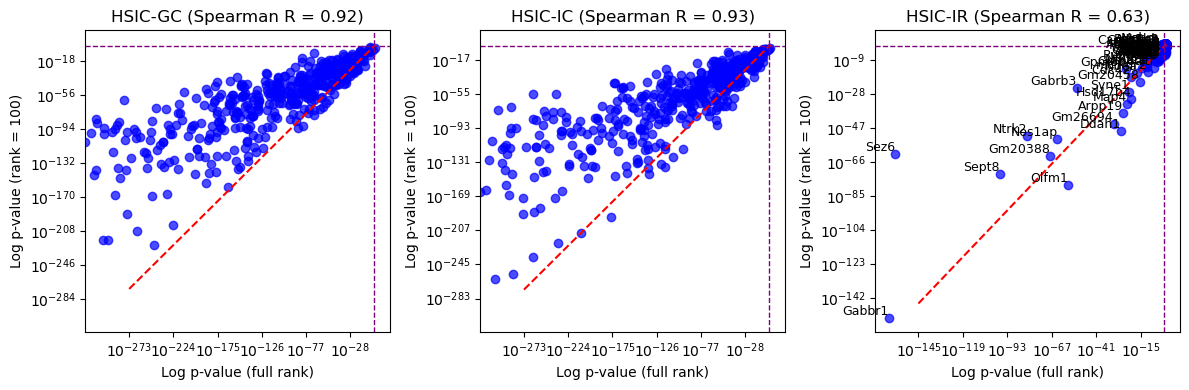

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Create a single figure with three subplots in one row
fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # 1 row, 3 columns

# HSIC-GC
x = df['pvalue_hsic-gc_fullrank']
y = df['pvalue_hsic-gc_lowrank']

axes[0].scatter(x, y, color='blue', alpha=0.7, label="Data points")
x_line = np.logspace(-273, 0, 1000)
axes[0].plot(x_line, x_line, color='red', linestyle='--')
axes[0].axvline(x=0.05, color='purple', linestyle='--', linewidth=1)
axes[0].axhline(y=0.05, color='purple', linestyle='--', linewidth=1)
axes[0].set_title(f"HSIC-GC (Spearman R = {scipy.stats.spearmanr(x, y)[0]:.2f})")

# HSIC-IC
x = df['pvalue_hsic-ic_fullrank']
y = df['pvalue_hsic-ic_lowrank']

axes[1].scatter(x, y, color='blue', alpha=0.7, label="Data points")
x_line = np.logspace(-273, 0, 1000)
axes[1].plot(x_line, x_line, color='red', linestyle='--')
axes[1].axvline(x=0.05, color='purple', linestyle='--', linewidth=1)
axes[1].axhline(y=0.05, color='purple', linestyle='--', linewidth=1)
axes[1].set_title(f"HSIC-IC (Spearman R = {scipy.stats.spearmanr(x, y)[0]:.2f})")

# HSIC-IR
x = df['pvalue_hsic-ir_fullrank']
y = df['pvalue_hsic-ir_lowrank']

axes[2].scatter(x, y, color='blue', alpha=0.7, label="Data points")
x_line = np.logspace(-145, 0, 1000)
axes[2].plot(x_line, x_line, color='red', linestyle='--')
axes[2].axvline(x=0.05, color='purple', linestyle='--', linewidth=1)
axes[2].axhline(y=0.05, color='purple', linestyle='--', linewidth=1)
axes[2].set_title(f"HSIC-IR (Spearman R = {scipy.stats.spearmanr(x, y)[0]:.2f})")

# Add annotations for significant points
for index, row in df.iterrows():
    if row['padj_hsic-ir_fullrank'] < 0.01:
        axes[2].text(
            row['pvalue_hsic-ir_fullrank'], row['pvalue_hsic-ir_lowrank'], 
            index, fontsize=9, color='black', ha='right', va='bottom'
        )

for i, ax in enumerate(axes):
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Log p-value (full rank)')
    ax.set_ylabel('Log p-value (rank = 100)')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

#### Visualize specific examples

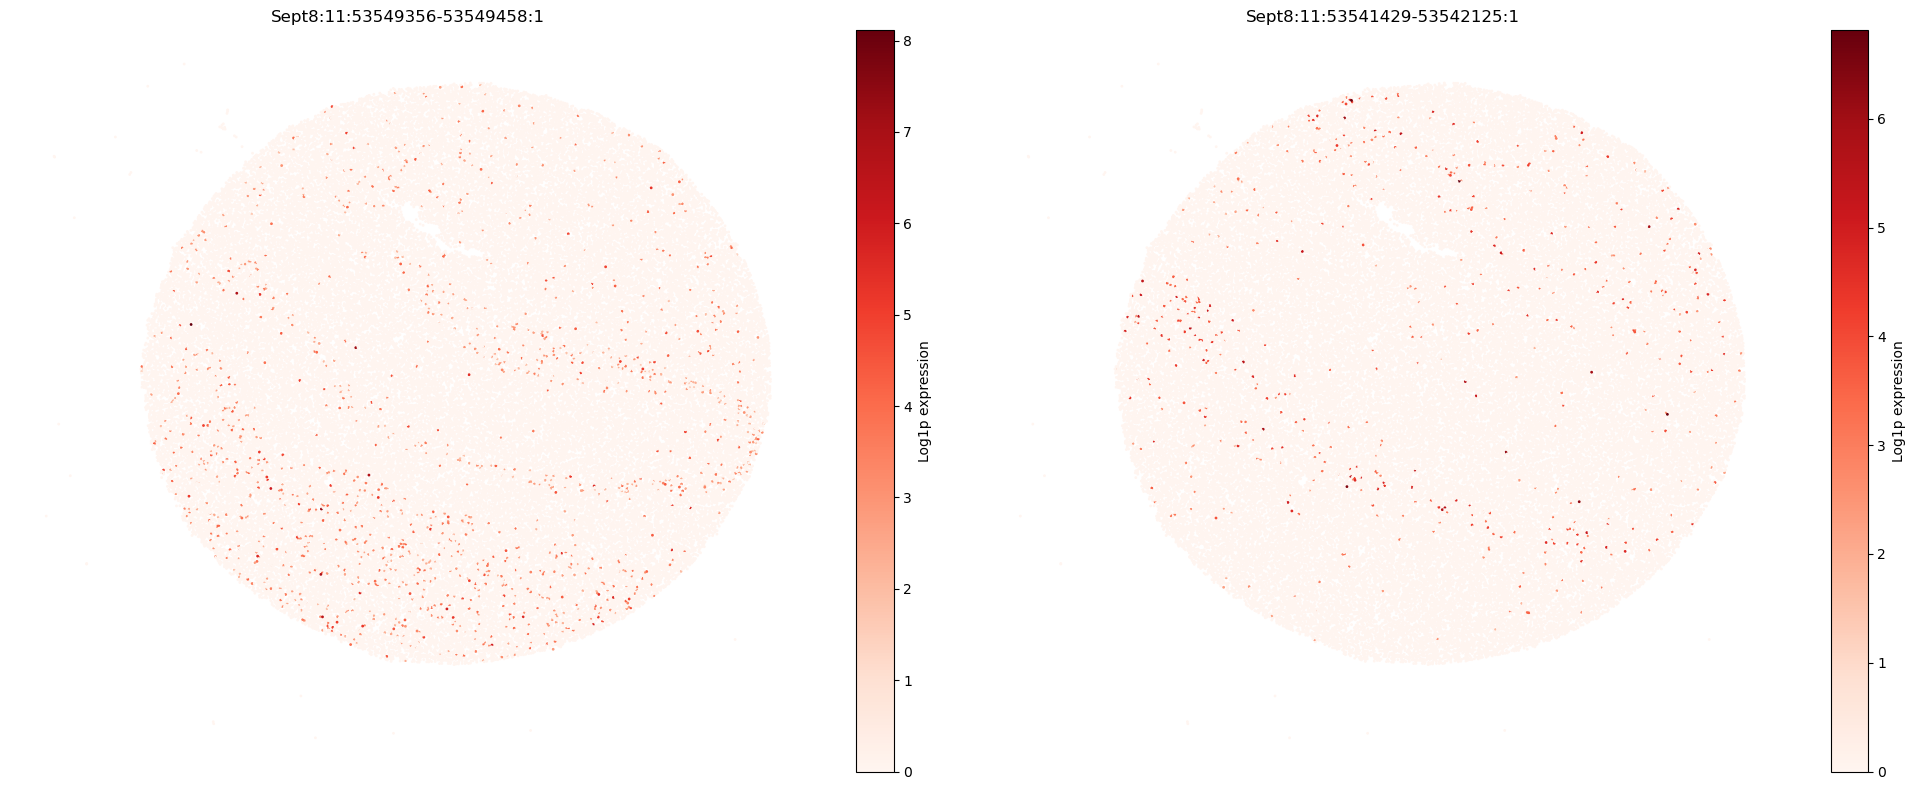

In [22]:
# Get the list of isoform names
iso_names = adata.var_names[adata.var['gene_id'] == 'Sept8']

# Create subplots with the appropriate number of panels
num_vars = len(iso_names)
fig, axes = plt.subplots(1, num_vars, figsize=(10 * num_vars, 8))  # Adjust width based on the number of variables

# Loop over each variable and create a scatter plot
for i, iso in enumerate(iso_names):
    # Extract color variable for the current gene
    color_variable = adata[:, iso].layers['log1p'].toarray()
    
    # Create scatter plot in the corresponding subplot
    scatter = axes[i].scatter(
        coords['array_row'], coords['array_col'], 
        c=color_variable, cmap='Reds', s=1, alpha=1
    )
    
    # Add colorbar
    cbar = fig.colorbar(scatter, ax=axes[i])
    cbar.set_label(f'Log1p expression')
    
    # Set title and labels
    axes[i].set_title(f'{iso}')
    axes[i].axis('off')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()